In [1]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
clean_hin_dataset = open("datasets\cleaned_hinenglish.txt").read().splitlines()

In [3]:
#building the mappings like tokeniser

clean = sorted(set(''.join(clean_hin_dataset)))
stoi = {s:i for i,s in enumerate(clean)}
stoi['.'] = 27
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
data_size = len(clean_hin_dataset)

In [4]:
# Convert all text into a single string
full_text = ' '.join(clean_hin_dataset)
full_text_idx = [stoi[ch] for ch in full_text]  # Convert to indices

seq_length = 50  # sliding window size
Xtrain, Ytrain = [], []

for i in range(len(full_text_idx) - seq_length):
    Xtrain.append(full_text_idx[i : i + seq_length])
    Ytrain.append(full_text_idx[i + 1 : i + seq_length + 1])

Xtrain = torch.tensor(Xtrain, dtype=torch.long)
Ytrain = torch.tensor(Ytrain, dtype=torch.long)

print("Xtrain shape:", Xtrain.shape)  # (num_examples, 25)
print("Ytrain shape:", Ytrain.shape)  # (num_examples, 25)

Xtrain shape: torch.Size([131374, 50])
Ytrain shape: torch.Size([131374, 50])


In [6]:
X = Xtrain[0]
Y = Ytrain[0]
X.shape,Y.shape

(torch.Size([50]), torch.Size([50]))

In [19]:
hidden_size = 200  # size of the hidden state
g = torch.Generator().manual_seed(2347243647)

Wxi = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whi = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Wxf = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whf = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Wxo = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Who = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Wxg = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whg = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Bi = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
Bf = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
Bo = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
Bg = torch.zeros((hidden_size, 1)) # hidden bias (100,1)

Why = torch.randn((vocab_size, hidden_size), generator=g) * 0.01  # (28,100)
By = torch.zeros((vocab_size, 1)) # output bias (28,1)

parameters = [Wxi, Whi, Wxf, Whf, Wxo, Who, Wxg, Whg, Bi, Bf, Bo, Bg, Why, By]
count = 0
for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters
    count += p.nelement()
count

188828

In [20]:
lossi, steps = [], []

In [21]:
sequence_length = 50  

hprev = torch.zeros((hidden_size, 1))  # initial hidden state (200,1)
cprev = torch.zeros((hidden_size, 1))  # initial cell state (200,1)
loss = 0  # initialize loss

for i in range(20000):
    X = Xtrain[0] #50 shape
    Y = Ytrain[0] #50 shape

    hprev = torch.zeros((hidden_size, 1))  # initial hidden state (200,1)
    cprev = torch.zeros((hidden_size, 1))  # initial cell state (200,1)

    loss = 0  # reset loss for each sequence


    for t in range(sequence_length):
        xs_t = torch.zeros((vocab_size, 1))  # input (28,1)
        xs_t[X[t]] = 1  # one-hot encoding

        i_t = torch.sigmoid(Wxi @ xs_t + Whi @ hprev + Bi)  # input gate (100,1)
        f_t = torch.sigmoid(Wxf @ xs_t + Whf @ hprev + Bf)  # forget gate (100,1)
        o_t = torch.sigmoid(Wxo @ xs_t + Who @ hprev + Bo)  # output gate (100,1)
        g_t = torch.tanh(Wxg @ xs_t + Whg @ hprev + Bg)  # cell gate (100,1)

        c_t = f_t * cprev + i_t * g_t  # cell state (100,1)
        h_t = o_t * torch.tanh(c_t)  # hidden state (100,1)

        y_t = Why @ h_t + By  # output (28,1)

        loss += f.cross_entropy(y_t.T, Y[t].view(-1))  # cross-entropy loss

        hprev = h_t  # update hidden state
        cprev = c_t  # update cell state

    #reset hprev and cprev for the next sequence

    avg_loss = loss / sequence_length  # average loss over the sequence length
    perplexity = torch.exp(avg_loss)  # calculate perplexity
    
    for p in parameters:
        p.grad = None
    avg_loss.backward()

    
    # Update parameters using gradient descent
    lr = 0.001  # learning rate
    for p in parameters:
        p.data -= lr * p.grad


    steps.append(i)
    lossi.append(loss.item())

    if i % 1000 == 0:
        print(f"Perplexity at step {i}: {perplexity.item()}")
        print(f"Step {i}, Loss: {avg_loss.item()}")

print(f"Final loss: {avg_loss.item()}")

Perplexity at step 0: 28.00233268737793
Step 0, Loss: 3.3322877883911133
Perplexity at step 1000: 26.596593856811523
Step 1000, Loss: 3.280783176422119
Perplexity at step 2000: 25.35790252685547
Step 2000, Loss: 3.233090400695801
Perplexity at step 3000: 24.26797866821289
Step 3000, Loss: 3.189157724380493
Perplexity at step 4000: 23.310354232788086
Step 4000, Loss: 3.148897647857666
Perplexity at step 5000: 22.470104217529297
Step 5000, Loss: 3.1121857166290283
Perplexity at step 6000: 21.733617782592773
Step 6000, Loss: 3.078860282897949
Perplexity at step 7000: 21.088502883911133
Step 7000, Loss: 3.0487279891967773
Perplexity at step 8000: 20.523527145385742
Step 8000, Loss: 3.0215718746185303
Perplexity at step 9000: 20.028472900390625
Step 9000, Loss: 2.997154951095581
Perplexity at step 10000: 19.59419822692871
Step 10000, Loss: 2.975233554840088
Perplexity at step 11000: 19.21251106262207
Step 11000, Loss: 2.955561637878418
Perplexity at step 12000: 18.876157760620117
Step 12000

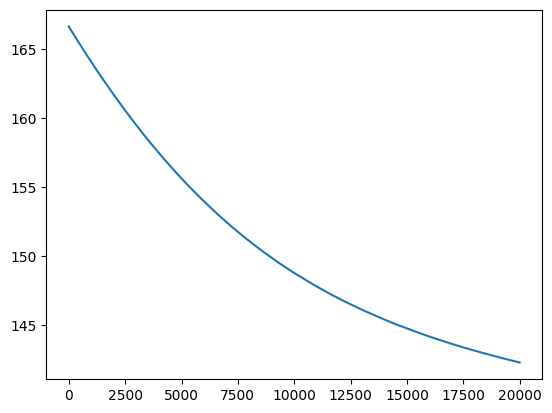

In [22]:
plt.plot(steps, lossi)